In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# HYPERPARAMETRERS AND DIRECTORIES

In [24]:
train_dir = "train"
test_dir = "test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 4
EARLY_STOPPING_CRITERIA=7
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

# DATA LOADING AND PRE-PROCESSING

In [25]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [26]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# DenseNet169 Transfer Learning

In [2]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(48,48, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", 
                              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", 
                              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", 
                              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(4, activation="softmax",name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(48,48,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [3]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

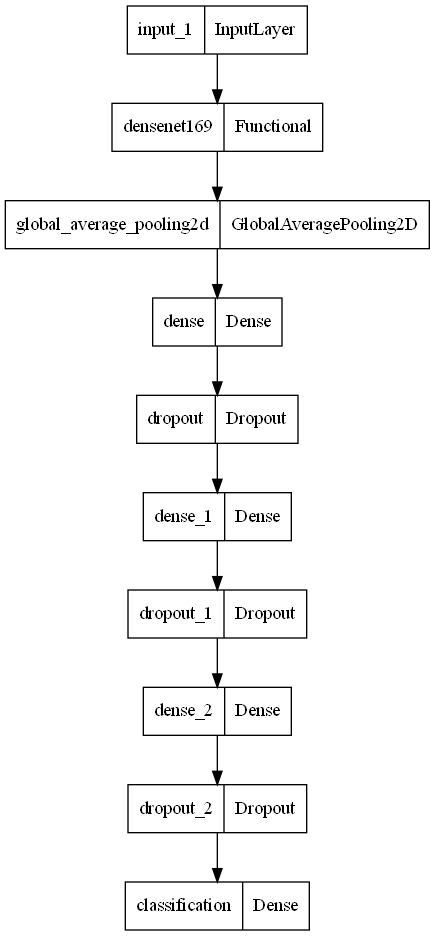

In [4]:
from keras.utils import plot_model
plot_model(model, to_file='model2.png')

# Training model with freezed layers of DenseNer169

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
with tf.device("/device:GPU:0"):
    history = model.fit(x = train_generator,
                        epochs = EPOCHS ,
                        validation_data = validation_generator , 
                        callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

# Fine Tuning

In [11]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
with tf.device("/device:GPU:0"):
    history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
206/206 [==============================] - 45s 148ms/step - loss: 0.7640 - accuracy: 0.7120 - val_loss: 0.8284 - val_accuracy: 0.6746
Epoch 2/20
206/206 [==============================] - 27s 131ms/step - loss: 0.7493 - accuracy: 0.7215 - val_loss: 0.8231 - val_accuracy: 0.6804
Epoch 3/20
206/206 [==============================] - 27s 131ms/step - loss: 0.7379 - accuracy: 0.7246 - val_loss: 0.8192 - val_accuracy: 0.6798
Epoch 4/20
206/206 [==============================] - 27s 130ms/step - loss: 0.7307 - accuracy: 0.7297 - val_loss: 0.8160 - val_accuracy: 0.6804
Epoch 5/20
206/206 [==============================] - 27s 129ms/step - loss: 0.7247 - accuracy: 0.7326 - val_loss: 0.8162 - val_accuracy: 0.6807
Epoch 6/20
206/206 [==============================] - 27s 131ms/step - loss: 0.7291 - accuracy: 0.7278 - val_loss: 0.8130 - val_accuracy: 0.6834
Epoch 7/20
206/206 [==============================] - 27s 131ms/step - loss: 0.7176 - accuracy: 0.7341 - val_loss: 0.8122 - val_ac

# Evaluating model

In [12]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

82/82 [==============================] - 7s 40ms/step


# Visualizing Train,Test--->Accuracy,Loss

<Figure size 640x480 with 0 Axes>

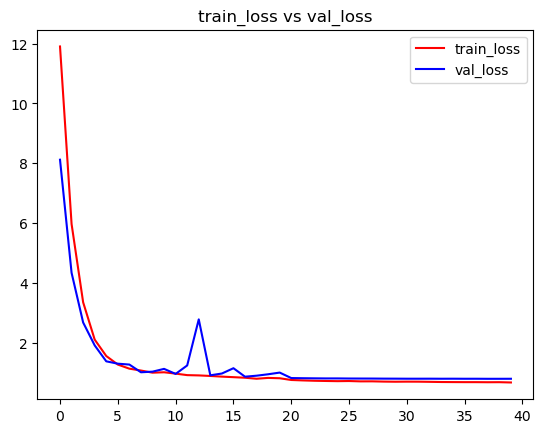

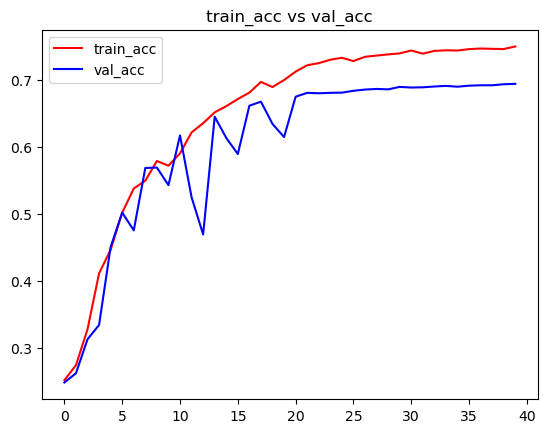

<Figure size 640x480 with 0 Axes>

In [13]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history['loss']
val_loss=history['val_loss']
train_acc=history['accuracy']
val_acc=history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [14]:
# Model Save
model.save_weights('model_weights.h5')
model.save('model_densenet2.h5')

# Confusion Matrix

In [15]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)

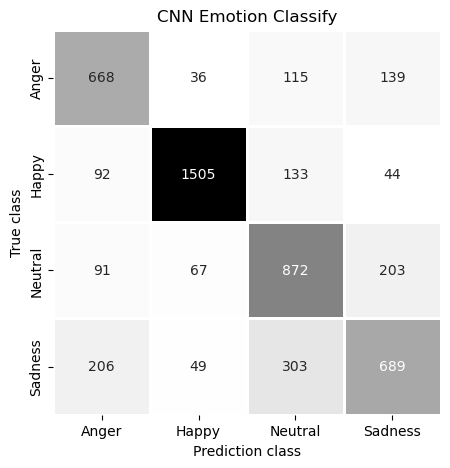

In [16]:
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

# Classification Report

In [17]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       958
           1       0.91      0.85      0.88      1774
           2       0.61      0.71      0.66      1233
           3       0.64      0.55      0.59      1247

    accuracy                           0.72      5212
   macro avg       0.70      0.70      0.70      5212
weighted avg       0.72      0.72      0.72      5212



# ROC Curve

ROC AUC score: 0.9098783834538122


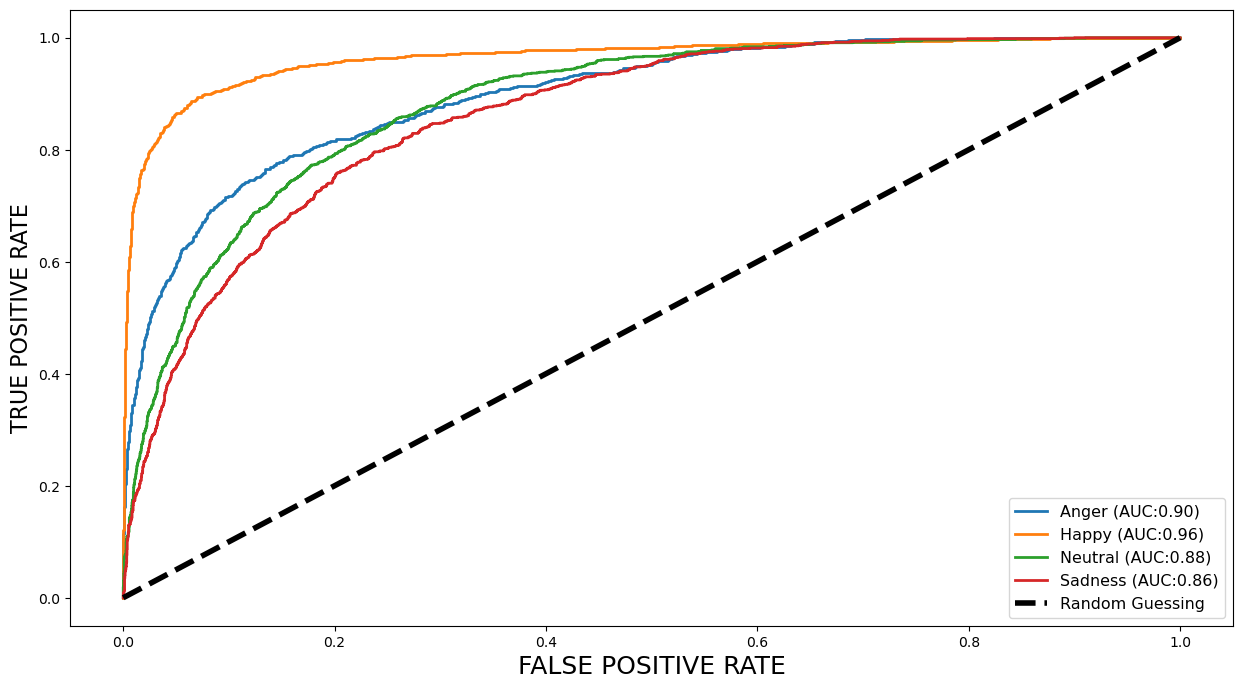

In [18]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [19]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.9014887283833808
